In [90]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import json
import numpy as np
import os

# json_file = 'Data\D1_flexion_golden_repetition.json'
# json_file = 'Data\python_lbue4-loop_720p_flip.json'
# json_file = 'Data\python_md54-side-loop_720p_flip.json'
# json_file = 'Data\python_md55-loop_720p_flip.json'
json_file_ref = 'Data\squat_golden_repetition.json'
# json_file = '/content/jitter.json'
# json_file = 'Data\jitter.json'
json_file = 'Data\Squat/6fa4d990-3322-42b0-8122-517d8aec998c.json'
# json_file = 'Data\Squat/0573c3e3-6bb0-4535-a7fb-d35bed258204.json'
# json_file = 'Data\Squat/5776f824-d245-4502-a6df-9247d2e18daf.json'
# json_file = 'Data\Squat/38501fd4-6b0d-4519-8968-a922d60e850b.json'
# json_file = 'Data\Squat/06434864-3644-4c2b-8856-0ed30f0bd243.json'
# json_file = 'Data\Squat/11948402-84fd-4bcf-ae35-664b44166822.json'
# json_file = 'Data\Squat/bebe7db0-cd90-4da0-bee3-679f1b11e4a6.json'
# json_file = 'Data\YW/7d8d0f81-e583-49fd-a6d4-01fb584e18c5.json'

# Load the data
with open(json_file, 'r') as file:
    data = json.load(file)

with open(json_file_ref, 'r') as file:
    data_ref = json.load(file)


In [91]:
def get_body_parts(data):
    """
    This function returns 'body_parts' dictionary, that links the name of the body part, with its index.
    """
    try:
        body_parts = {node['name']: node['index'] for node in data['used_nodes']}
    except KeyError:
        # Some exercises (f.e. 'D1_flexion) do not contain the 'used_nodes' key, so let's assume the following:
        body_parts = {
            'NOSE': 0,
            'LEFT_EYE': 1,
            'RIGHT_EYE': 2,
            'LEFT_EAR': 3,
            'RIGHT_EAR': 4,
            'LEFT_SHOULDER': 5,
            'RIGHT_SHOULDER': 6,
            'LEFT_ELBOW': 7,
            'RIGHT_ELBOW': 8,
            'LEFT_WRIST': 9,
            'RIGHT_WRIST': 10,
            'LEFT_HIP': 11,
            'RIGHT_HIP': 12,
            'LEFT_KNEE': 13,
            'RIGHT_KNEE': 14,
            'LEFT_FOOT': 15,
            'RIGHT_FOOT': 16
        }
    return body_parts

def get_list_of_positions(data):
    """
    This function preprocesses the 'golden_rep_poses' key into a list of frames.
    Each frame is a list of tuples (x, y) representing the position of each node.
    """
    list_of_positions = []
    try:
        for timestamp in data['golden_rep_poses']:
            positions = timestamp['pose']
            list_of_tuples_for_each_timestamp = [
                [positions[i], positions[i+1]] for i in range(0, 34, 2)
            ]
            list_of_positions.append(list_of_tuples_for_each_timestamp)
    except KeyError:
        try:
            pose_data = data["golden_video_metadata"]["pose"]

            for pose in pose_data:
                pose = pose[1:] # first element is a time
                list_of_tuples_for_each_pose = [
                    [pose[i], pose[i+1]] for i in range(0, 34, 2)
                ]
                list_of_positions.append(list_of_tuples_for_each_pose)
        except:
            try:
                pose_data = data["user_poses"]

                for index in pose_data:
                    pose = index['pose']
                    list_of_tuples_for_each_pose = [
                        [pose[i], pose[i+1]] for i in range(0, 34, 2)
                    ]
                    list_of_positions.append(list_of_tuples_for_each_pose)
            except:
                try:
                    pose_data = data['record']['results']
                    
                    for index in pose_data:
                        pose = index['input_pose']['pose']
                        list_of_tuples_for_each_pose = [
                            [pose[i], pose[i+1]] for i in range(0, 34, 2)
                        ]
                        list_of_positions.append(list_of_tuples_for_each_pose)
                except:
                    pose_data = data['results']
                    
                    for index in pose_data:
                        pose = index['input_pose']['pose']
                        list_of_tuples_for_each_pose = [
                            [pose[i], pose[i+1]] for i in range(0, 34, 2)
                        ]
                        list_of_positions.append(list_of_tuples_for_each_pose)

    return list_of_positions

def differecne_measurment(list_of_positions, reference_node, body_parts):
    """Comes in handy whenever actor flies over the screen"""
    reference_index = body_parts[reference_node]
    for frame in list_of_positions:
        ref_x = frame[reference_index][0]
        ref_y = frame[reference_index][1]
        for node in frame:
            node[0] -= (ref_x - 0.5)
            node[1] -= (ref_y - 0.5)
    return list_of_positions

def transform_list_of_positions(list_of_positions, scale_to_pixels=True):
    """the function can be extended, for now I need only to reflect the node by liney=0.5, as the image is
    upside-down

    When we will need to add a scale it's a good place to do so.

    """
    for frame in list_of_positions:
        for node in frame:
            node[1] = -node[1]+1
            if scale_to_pixels:
                node[0] = int(node[0]*720)
                node[1] = int(node[1]*1280)
            # print(node)

    return list_of_positions

def smooth_positions(list_of_positions, window_size=5):
    """Applies a moving average filter to smooth the positions of each node over time."""
    smoothed_positions = []
    for i in range(len(list_of_positions)):
        if i < window_size:
            smoothed_positions.append(list_of_positions[i])
        else:
            smoothed_frame = []
            for j in range(len(list_of_positions[i])):
                smoothed_x = np.mean([list_of_positions[k][j][0] for k in range(i-window_size, i+1)])
                smoothed_y = np.mean([list_of_positions[k][j][1] for k in range(i-window_size, i+1)])
                smoothed_frame.append([smoothed_x, smoothed_y])
            smoothed_positions.append(smoothed_frame)
    return smoothed_positions

def center_skeleton(list_of_positions):
    """Centers the skeleton in the frame by shifting all coordinates."""
    for frame in list_of_positions:
        # Calculate the center of the skeleton
        x_coords = [node[0] for node in frame]
        y_coords = [node[1] for node in frame]
        center_x = np.mean(x_coords)
        center_y = np.mean(y_coords)

        # Shift all nodes to center the skeleton
        for node in frame:
            node[0] -= center_x - 0.5  # Centering on the x-axis (0.5 is the center)
            node[1] -= center_y - 0.5  # Centering on the y-axis (0.5 is the center)
    return list_of_positions

def add_fake_point_between_A_and_B(A, B, list_of_positions, body_parts, name):
    """
    Adds a fake point between points A and B and appends it to each frame in list_of_positions.
    """
    for frame in list_of_positions:
        fake_point_x = (frame[body_parts[A]][0] + frame[body_parts[B]][0]) / 2
        fake_point_y = (frame[body_parts[A]][1] + frame[body_parts[B]][1]) / 2
        frame.append((fake_point_x, fake_point_y))
    body_parts[name] = len(body_parts)

def get_trace(node, list_of_positions, body_parts):
    trace = []
    node_index = body_parts[node]
    for frame in list_of_positions:
        trace.append(frame[node_index])

    return trace

def get_velocity(trace):
    x_vel = []
    y_vel = []
    for frame in trace:
        x_vel.append(frame[0])
        y_vel.append(frame[1])

    return np.gradient(np.array(x_vel)), np.gradient(np.array(y_vel))


import math
def get_angle(A, B, C, list_of_positions, body_parts):
    angles = []
    for frame in list_of_positions:
        a = frame[body_parts[A]]
        b = frame[body_parts[B]]
        c = frame[body_parts[C]]

        BA = [a[0] - b[0], a[1] - b[1]]
        BC = [c[0] - b[0], c[1] - b[1]]
        
        # Dot product of BA and BC
        dot_product = BA[0] * BC[0] + BA[1] * BC[1]
        
        # Magnitudes of BA and BC
        magnitude_BA = math.sqrt(BA[0]**2 + BA[1]**2)
        magnitude_BC = math.sqrt(BC[0]**2 + BC[1]**2)
        
        # Cosine of the angle
        cos_angle = dot_product / (magnitude_BA * magnitude_BC)
        
        # Angle in radians
        angle_radians = math.acos(cos_angle)
        
        # Convert to degrees
        angle_degrees = math.degrees(angle_radians)
        angles.append(angle_degrees)

    return angles

HUMAN_BLUEPRINT = [
    ('LEFT_SHOULDER', 'LEFT_ELBOW'), ('LEFT_ELBOW', 'LEFT_WRIST'),
    ('RIGHT_SHOULDER', 'RIGHT_ELBOW'), ('RIGHT_ELBOW', 'RIGHT_WRIST'),
    ('RIGHT_SHOULDER', 'LEFT_SHOULDER'), ('RIGHT_HIP', 'LEFT_HIP'),
    ('LEFT_HIP', 'LEFT_KNEE'), ('LEFT_KNEE', 'LEFT_FOOT'),
    ('RIGHT_HIP', 'RIGHT_KNEE'), ('RIGHT_KNEE', 'RIGHT_FOOT')
]

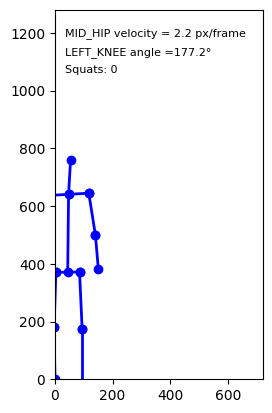

In [92]:
body_parts = get_body_parts(data)
list_of_positions = get_list_of_positions(data)
list_of_positions = transform_list_of_positions(list_of_positions)
list_of_positions = differecne_measurment(list_of_positions, 'LEFT_FOOT', body_parts)

# Smooth the positions
list_of_positions = smooth_positions(list_of_positions, window_size=5)

# Add fake point between hips to visualise the spine
add_fake_point_between_A_and_B('RIGHT_HIP', 'LEFT_HIP', list_of_positions, body_parts, 'MID_HIP')
add_fake_point_between_A_and_B('RIGHT_SHOULDER', 'LEFT_SHOULDER', list_of_positions, body_parts, 'MID_SHOULDER')


# Add the connection from the MID_HIP to the NOSE
HUMAN_BLUEPRINT.append(('MID_HIP', 'MID_SHOULDER'))
HUMAN_BLUEPRINT.append(('MID_SHOULDER', 'NOSE'))

# Convert HUMAN_BLUEPRINT to indexes
connections = [(body_parts[start], body_parts[end]) for start, end in HUMAN_BLUEPRINT]

trace = get_trace('MID_HIP', list_of_positions, body_parts)
x_vel, y_vel = get_velocity(trace)
velocity = np.sqrt(x_vel**2 + y_vel**2)

angles_lk = get_angle('LEFT_FOOT', 'LEFT_KNEE', 'LEFT_HIP', list_of_positions, body_parts)
angles_rk = get_angle('RIGHT_FOOT', 'RIGHT_KNEE', 'RIGHT_HIP', list_of_positions, body_parts)
angles_mean = []

for l, r in zip(angles_lk, angles_rk):
    angles_mean.append((l+r)/2)


# Initialize squat counting variables
squat_count = 0
is_squatting = False
ANGLE_THRESHOLD = 140  # Define a threshold angle for squats


fig, ax = plt.subplots()
plt.gca().set_aspect('equal', adjustable='box')

ax.set_xlim(0, 720)
ax.set_ylim(0, 1280)

lines = [ax.plot([], [], 'bo-', lw=2)[0] for _ in connections]
trace_line, = ax.plot([], [], 'r-', lw=1)
velocity_text = ax.text(0.3, 0.7, '', transform=ax.transAxes, color='black', fontsize=8, verticalalignment='top')
angle_text = ax.text(0.3, 0.7, '', transform=ax.transAxes, color='black', fontsize=8, verticalalignment='top')
squat_text = ax.text(0.05, 0.85, '', transform=ax.transAxes, color='black', fontsize=8, verticalalignment='top')


def animate(i):
    """Update the animation with each frame."""
    frame = list_of_positions[i]
    for line, (start, end) in zip(lines, connections):
        x = [frame[start][0], frame[end][0]]
        y = [frame[start][1], frame[end][1]]
        line.set_data(x, y)

    if i < len(trace):
        current_angle = angles_mean[i]
        trace_x = [pos[0] for pos in trace[:i+1]]
        trace_y = [pos[1] for pos in trace[:i+1]]
        trace_line.set_data(trace_x, trace_y)

        global squat_count, is_squatting
        if current_angle < ANGLE_THRESHOLD and not is_squatting:
            is_squatting = True
        elif current_angle > ANGLE_THRESHOLD and is_squatting:
            squat_count += 1
            is_squatting = False

    current_angle = angles_lk[i]
    angle_text.set_text(f'LEFT_KNEE angle ={round(current_angle, 1)}°')
    
    angle_text.set_position((0.05, 0.9))
    velocity_text.set_position((0.05, .95))
    squat_text.set_text(f'Squats: {squat_count}')

    current_velocity = velocity[i]
    velocity_text.set_text(f'MID_HIP velocity = {round(current_velocity, 1)} px/frame')
    
    # Position the velocity text in the upper right corner
    # velocity_text.set_position((trace_x[-1]/720, trace_y[-1]/1280))

    return lines + [trace_line]


# Create animation
ani = FuncAnimation(fig, animate, frames=len(list_of_positions), interval=100, blit=True)
# os.makedirs('Animations', exist_ok=True)
gif_path = 'Animations/'+json_file[5:-5] + '_animation.gif'
# ani.save(gif_path, writer=PillowWriter(fps=30))

plt.show()

Text(0, 0.5, 'Angle [°]')

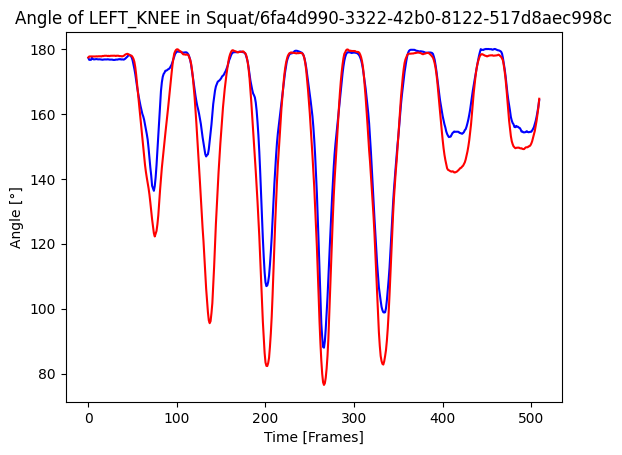

In [93]:
plt.title(f'Angle of LEFT_KNEE in {json_file[5:-5]}')
plt.plot(angles_lk, 'b')
plt.plot(angles_rk, 'r')
plt.xlabel('Time [Frames]')
plt.ylabel('Angle [°]')

# from scipy.signal import find_peaks

# peaks, _ = find_peaks(angles_lk, height=10)
# print(peaks)
# print(peaks)
# plt.scatter(peaks, np.ones(len(peaks)))
# plt.savefig(f'Plots/Angle of LEFT_KNEE in {json_file[5:-5]}.png')


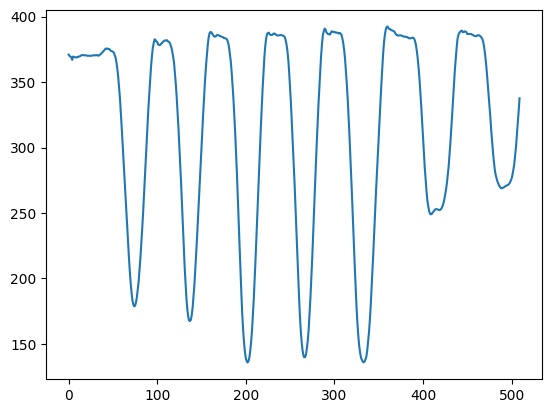

In [94]:
# print(trace)
_, y = zip(*trace)
plt.plot(y)

In [95]:
body_parts_ref = get_body_parts(data_ref)
list_of_positions_ref = get_list_of_positions(data_ref)
list_of_positions_ref = differecne_measurment(list_of_positions_ref, 'LEFT_FOOT', body_parts_ref)
list_of_positions_ref = transform_list_of_positions(list_of_positions_ref)
# list_of_positions = differecne_measurment(list_of_positions, 'LEFT_HIP', body_parts)

# Smooth the positions
list_of_positions_ref = smooth_positions(list_of_positions_ref, window_size=5)

# Add fake point between hips to visualise the spine
add_fake_point_between_A_and_B('RIGHT_HIP', 'LEFT_HIP', list_of_positions_ref, body_parts_ref, 'MID_HIP')
add_fake_point_between_A_and_B('RIGHT_SHOULDER', 'LEFT_SHOULDER', list_of_positions_ref, body_parts_ref, 'MID_SHOULDER')


In [96]:
def normalize(data):
    data = np.array(data)
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    return (data - min_vals) / (max_vals - min_vals)


trace = get_trace('MID_HIP', list_of_positions, body_parts)
trace_ref = get_trace('MID_HIP', list_of_positions_ref, body_parts_ref)

test_normalized = normalize(trace)
golden_normalized = normalize(trace_ref)

print(len(golden_normalized))
print(len(test_normalized))

98
510


In [99]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

def sliding_window_dtw(golden_data, test_data, window_size):
    golden_length = len(golden_data)
    num_reps = 0
    dtw_distances = []

    for i in range(0, len(test_data) - golden_length + 1, window_size):
        test_segment = test_data[i:i + golden_length]
        distance, _ = fastdtw(golden_data, test_segment, dist=euclidean)
        dtw_distances.append((distance, i))

    # Find best alignments
    dtw_distances.sort()
    threshold_distance = dtw_distances[0][0] * 1.01  # Allow a small margin

    for distance, index in dtw_distances:
        if distance <= threshold_distance:
            num_reps += 1
            # Skip the segment to avoid counting overlapping repetitions
            i += golden_length

    return num_reps, dtw_distances

window_size = 1  # Move one frame at a time
num_reps, dtw_distances = sliding_window_dtw(golden_normalized, test_normalized, window_size)
print(f"Number of repetitions: {num_reps}")

Number of repetitions: 4
